In [21]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
raw_data = pd.read_csv('epi_r.csv')

In [23]:
#list(raw_data.columns)
#raw_data.head()
raw_data.shape

(20052, 680)

In [6]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

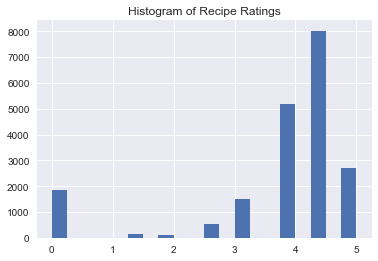

In [7]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [10]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [11]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

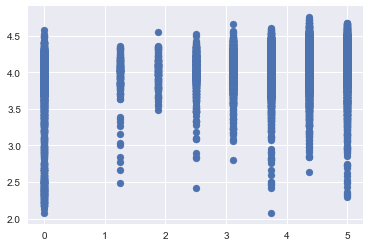

In [15]:
plt.scatter(Y, svr.predict(X))

In [16]:
svr.score(X, Y)

0.038565706512988962

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

array([ 0.01818511,  0.026411  ,  0.03037705,  0.01957949,  0.02451197])

### Assignment:

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here.

1. The overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.
2. We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.
3. We could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possibly value, group reviews to some decided high and low values.

And that is your challenge.
Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.
Good luck!
When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

In [22]:
## make a new feature set using pca
# run PCA (either number of final components or amount of variance explained(how?))

sklearn_pca = PCA(n_components=10)
X
Y_sklearn = sklearn_pca.fit_transform(X)

cross_val_score(svr, Y_sklearn, Y, cv=10)


array([ 0.0354446 , -0.01391068,  0.02496167,  0.01909188,  0.01846063,
        0.08572129,  0.04150868, -0.00856294, -0.02970871,  0.06752312])

In [24]:
sklearn_pca = PCA(n_components=100)
Y_sklearn = sklearn_pca.fit_transform(X)

cross_val_score(svr, Y_sklearn, Y, cv=10)

array([ 0.05935057,  0.01734818,  0.04082095,  0.06332312,  0.03600907,
        0.08467734,  0.05133204,  0.0488251 ,  0.01742924,  0.07523436])

In [25]:
## recreate target with a binary values rating >3 = 1, else 0
threshold = 3
Y_binary = np.where(Y > threshold, 1, 0)

In [26]:
svr.fit(X,Y_binary)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [27]:
svr.score(X, Y_binary)

0.079371432109671014

In [28]:
svr.fit(Y_sklearn,Y_binary)
svr.score(Y_sklearn, Y_binary)

0.09387059894131633

In [33]:
# drop nulls re-add nutrition content to feature dataset

X_Nutrition = raw_data.dropna()
Y_binary = np.where(X_Nutrition['rating'] > threshold, 1, 0)
X_Nutrition = X_Nutrition.drop(['rating', 'title'],axis=1)

X_Nutrition.shape

svr.fit(X_Nutrition,Y_binary)
svr.score(X_Nutrition, Y_binary)

0.36355482767946118

In [34]:
sklearn_pca = PCA(n_components=100)
X_Nutrition_PCA = sklearn_pca.fit_transform(X_Nutrition)
svr.fit(X_Nutrition_PCA,Y_binary)
svr.score(X_Nutrition_PCA, Y_binary)

0.73275690846801533

#### Conclusion: Final r2 .73
1. Removed the columns with null values
2. Created a binary input for rating (4-5 good, 1-3 not good) as the label
3. Added nutrition data back in
4. Used pca to reduce number of features